# Comparing Optimization Results using Active Subspaces and Derivative-Free Optimization on a Function with Additive Noise

In [1]:
import active_subspaces as ac
import numpy as np
import matplotlib.pyplot as plt

The function we use for demonstration is:

$$f: \mathbb{R}^{16} \to \mathbb{R}$$

$$f: \vec{x} \to f(\vec{x})$$

$$
f(\vec{x})=f((x_1,x_2,x_3,x_4,x_5,x_6,x_7,\ldots,x_{16})) = \alpha (x_1+x_2)^2+\beta (x_3+x_4)^2+\gamma (x_5+x_6)^2
$$

Notice we have defined $f$ to have no depedence on \{$x_7,\ldots,x_{16}$\}; to model those parameters as useless predictors, we will add a random noise factor $\epsilon$ to all function outputs, so that $$\texttt{pert_f}:=\tilde{f}(\vec{x})=f(\vec{x})+\epsilon.$$ The random noise factor $\epsilon$ is scaled to the unperturbed function output; in particular, we'll let $\epsilon \propto \left|\left|f(\vec{x})\right|\right|$.

We will explore what happens when $\alpha>\beta>\gamma$, with a relatively small additive random noise factor. This is a regime under which active subspace analysis is well-suited. Indeed, since the term $\alpha(x_1+x_2)$ contributes most to function outputs, the active subspace emerges as some linear combination $\eta^T\begin{bmatrix}
x_1\\
x_2\\
\end{bmatrix},$ where $\eta \in \mathbb{R}^2$. The components of $\eta$ are given by components in the eigenvectors computed either through Principal Component Analysis in gradient space (Russi) or through Active Subspace analysis (Constantine). To compare this analysis to the DF framework, we will not use an analytical gradient; instead, we can recycle the function evaluations from the DF algorithm to form our sample matrix in AS analysis, and to form a locally linear approximation to $\nabla f$.

We assume each variable has an a priori distribution of U[-1,1] to avoid normalization. We note this is a standard interval that we normalize to anyway (see Russi, Constantine). We perform $M=1000$ random draws on the hypercube $\Lambda:=[-1,1]^{16}$ and form the $M \times 16$ "input matrix" $A$ by transposing each sample into a $1\times 16$ row vector and stacking them into a matrix. The matrix $A$ is denoted with a lower $\texttt{a}$ in the notebook.

In [2]:
# Number of samples
M = 10000

# The input matrix
a = np.random.uniform(low=-1, high=1, size=(M,16))

# Parameters alpha, beta, gamma from our function
A = 1000 # alpha
B = 10 # beta
C = 1 # gamma

# An M x 1 column vector containing the evaluations of f at data points 1,...,M
def fun(a):
    
    a = a.copy()
    a = np.atleast_2d(a)
    M = a.shape[0]
    
    x = a[:,0]; y = a[:,1]; z = a[:,2]; w = a[:,3]; p = a[:,4]; q = a[:,5]; 
    
    return (A*(x+y)**2+B*(z+w)**2+C*(p+q)**2).reshape(M, 1)

def gun(a):
    
    a = a.copy()
    a = np.atleast_2d(a)
    M = a.shape[0]
    
    x = a[:,0]; y = a[:,1]; z = a[:,2]; w = a[:,3]; p = a[:,4]; q = a[:,5]; 
    
    return (A*np.sin(x+y)**2+B*(z+w)**2+C*np.cos(p+q)**2).reshape(M, 1)

def hun(a):
    
    a = a.copy()
    a = np.atleast_2d(a)
    M = a.shape[0]
    
    x = a[:,0]; y = a[:,1]; z = a[:,2]; w = a[:,3]; p = a[:,4]; q = a[:,5]; 
    
    return (A*(x**2+y)+2*B*(z+w)**100+C*(p+q+x**3)**2).reshape(M, 1)

# The function's output
f = fun(a)
g=gun(a)
h=hun(a)

# Global noise proportionality constant
k = 1e-6

# Perturbed function output
pert_f=fun(a)+np.linalg.norm(fun(a))*k*(2*(np.random.rand(M,1))-np.ones((M,1)))

For AS analysis, we mimic Paul Constantine's "basic" tutorial in his active subspaces library on GitHub, using a different toy function. All text directly copied from Paul's original notebook are cited with quotations throughout this notebook. Let $A_k$ denote the $k$-th row of $A$, which is the $k$-th of our $M$ samples of vectors in $[-1,1]^{16}$. 

We form a local linear approximation to the $\nabla \tilde{f}$, which we denote $\tilde{\nabla f}$. We evaluate the approximation at all $M$ samples, giving us $M$ $16 \times 1$ column vectors, $\tilde{\nabla f}(A_k^T)$, $k=1,\ldots,M$. Finally, we form the $M \times 16$ matrix

$$\texttt{noisy_grad_fun(a)}:=\texttt{grad_fun(a)}+E=\begin{bmatrix}
\tilde{\nabla f}(A_1^T)^T\\
\cdot \cdot \cdot\\
\tilde{\nabla f}(A_k^T)^T\\
\cdot \cdot \cdot \\
\tilde{\nabla f}(A_M^T)^T\\
\end{bmatrix}.$$

In order to "see" the important linear combinations in $\Lambda$, we print out the first of the eigenvectors formed in the AS analysis.

active_subspaces/gradients.py:61: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  u = np.linalg.lstsq(A, b)[0]


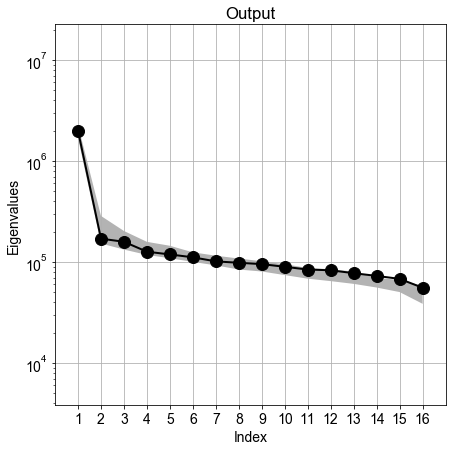

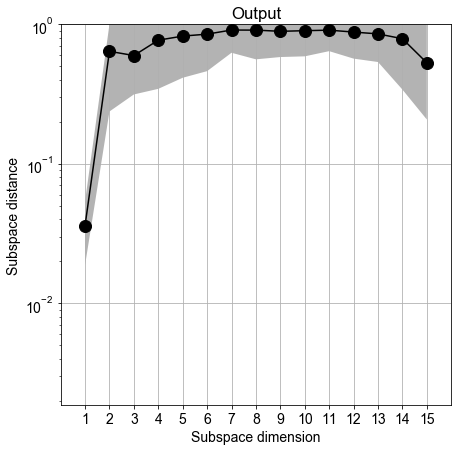

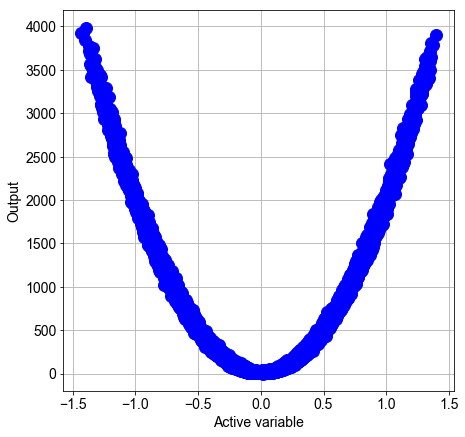

[0.70290037 0.49966501 0.23285697 0.28290242 0.00780095 0.16428116
 0.02898247 0.04764951 0.20544567 0.02930793 0.0133987  0.04549129
 0.11585545 0.10327095 0.08703878 0.12194754]
[ 0.71062364 -0.49082444 -0.24915159 -0.2634939  -0.01023464 -0.14606603
 -0.0349435  -0.05138027 -0.20701257 -0.04028525 -0.00245981 -0.06485601
 -0.117647   -0.10013729 -0.10148087 -0.12017786]


In [3]:
# LOCAL LINEAR APPROXIMATIONS TO GRAD(F)

#Instantiate a subspace object
ss = ac.subspaces.Subspaces()

df = ac.gradients.local_linear_gradients(a, pert_f) #Estimated gradients using local linear models

ss.compute(df=df, nboot=100)
ac.utils.plotters.eigenvalues(ss.eigenvals, ss.e_br)
ac.utils.plotters.subspace_errors(ss.sub_br)
ac.utils.plotters.sufficient_summary(a.dot(ss.W1), pert_f)

print(ss.eigenvecs)[0]
print(ss.eigenvecs)[1]

active_subspaces/utils/response_surfaces.py:105: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  poly_weights = np.linalg.lstsq(B, f)[0]


The R^2 value of the response surface is 0.8146


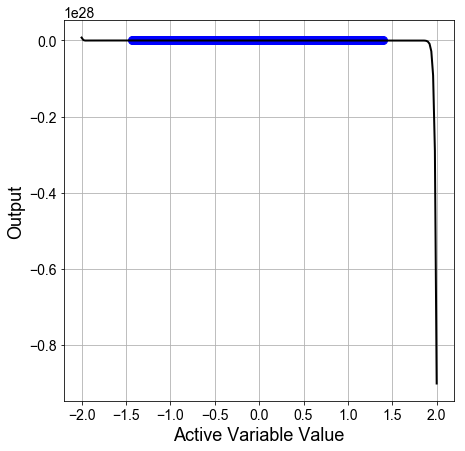

In [4]:
#quadratic polynomial approximation
RS = ac.utils.response_surfaces.PolynomialApproximation(100)

#Train the surface with active variable values (y = a.dot(ss.W1)) and perturbed function values (f)
y = a.dot(ss.W1)
RS.train(y, pert_f)
print 'The R^2 value of the response surface is {:.4f}'.format(RS.Rsqr)

#Plot the data and response surface prediction
plt.figure(figsize=(7, 7))
y0 = np.linspace(-2, 2, 200)
plt.plot(y, f, 'bo', y0, RS.predict(y0[:,None])[0], 'k-', linewidth=2, markersize=8)
plt.grid(True)
plt.xlabel('Active Variable Value', fontsize=18)
plt.ylabel('Output', fontsize=18)
plt.show()

In [5]:
#Minimize using the response surface

avdom = ac.domains.BoundedActiveVariableDomain(ss)
avmap = ac.domains.BoundedActiveVariableMap(avdom)
ystar, fstar = ac.optimizers.av_minimize(lambda x: RS.predict(x.reshape(1,1))[0], avdom) # had to change (1,1) to (1,3)
print 'The response surface optimization results are\n: ystar = {:.4f}, fstar = {:.4f}\n'.\
    format(ystar[0,0], fstar[0,0])


The response surface optimization results are
: ystar = -0.0204, fstar = 202.8454



In [6]:
#Minimize using scipy
import scipy.optimize as opt
#fun_n takes normalized inputs while fun takes unnormalized inputs
fun_n = lambda x: fun(x)
scipy_res = opt.minimize(fun_n, np.zeros(16), bounds=(zip(-1*np.ones(16), np.ones(16))))
print 'The scipy optimization results are:'
print 'xstar = {}, fstar = {:.4f}'.format(scipy_res['x'], scipy_res['fun'][0,0])
print 'xstar*W1 = {:.4f}'.format(scipy_res['x'].reshape((1, 16)).dot(ss.W1)[0,0])
print 'xstar*W2 = {:.4f}'.format(scipy_res['x'].reshape((1, 16)).dot(ss.W2)[0,0])

The scipy optimization results are:
xstar = [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.], fstar = 0.0000
xstar*W1 = 0.0000
xstar*W2 = 0.0000


In [7]:
# Derivative-Free Optimization using STARS Algorithm by Chen and Wild #

# Initialize #

# Set Maximum iteration counter
maxit=20


# Choose initial point and compute initial noisy function evaluation
x=0.1*np.ones(16)
print(x)

f=fun(x)[0,0] + np.linalg.norm(f)*k*(2*np.random.rand(1,1)-1)

F=k*np.linalg.norm(f)


# Smoothing parameter
mu_star=2e-5


# Step length
h=3.9e-5

# Have a look

print(f)
print(k)
print(F)

[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
[[40.38836627]]
1e-06
4.0388366272510165e-05


In [8]:
# STARS Algorithm #

#for i in range(1, maxit):
 #   u=np.random.normal(0,1,16)
    
 #   err=F*(2*np.random.rand(1,1) -1)
    
 #   g=fun(x+(mu_star)*u)[0,0] + err
    
 #   s=((g - f)/mu_star)*u 
    
 #   x=x - (h)*s 
    
 #   f=fun(x)[0,0] + err
    
#print(x)    
#print(f)
#print(np.linalg.norm(x))

In [9]:
# Testing out different projections and sizes
#x_r=x.reshape((16,1))
#print(x_r)
#print(ss.W1)
#print(x)
#x_A=(x.reshape((1, 16)).dot(ss.W1))*ss.W1
#x_A_r=x_A.reshape(1,16)
#print(x_A)
#print(x_A_r)

In [10]:
# Iterate both STARS and AS in tandem

# Set Maximum iteration counter for outside for loop
Maxit=1000


for i in range(1,Maxit):
    
    # STARS
    
    for i in range(1, maxit):
        u=np.random.normal(0,1,16)
    
        err=F*(2*np.random.rand(1,1) -1)
        
        g=fun(x+(mu_star)*u)[0,0] + err
    
        s=((g - f)/mu_star)*u 
    
        x=x - (h)*s 
    
        f=fun(x)[0,0] + err
    
    # Project the new x value into the active subspace ss.W1
    
    x=(x.reshape((1, 16)).dot(ss.W1))*ss.W1
    x=x.reshape(1,16)
    #print(x)
    
    f=fun(x)[0,0] + err
    #print(f)

print(x)    
print(f)
print(np.linalg.norm(x))

[[-9.57057295e-05 -9.67573177e-05  1.09696060e-06  1.75431363e-06
   3.43954400e-08  1.31194992e-06  1.36144023e-07 -1.88091079e-06
  -1.30937233e-07 -1.85607712e-06  2.52396588e-07  1.12635819e-06
   5.79748162e-07 -1.06478953e-06  1.03412300e-06  7.92433215e-07]]
[[9.63270018e-06]]
0.00013615831476466121
